# Import


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import  DataLoader, Dataset, Subset
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# config


In [2]:
# GPU Usage Guide:
# - For Apple Silicon Mac users:
#   1. Install `torch`, `torchaudio`, and `torchvision` first.
#   2. Use the following code with 'mps' to leverage GPU (Metal Performance Shaders) for training.
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# - For users with NVIDIA GPUs:
#   - If CUDA is available, you can use 'cuda' for GPU acceleration by replacing the code with:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

# classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# hyper-parameters (for generalization, not for tuning)
random_seed = 42
# random_seed = 1
# random_seed = 99

# hyper-parameters (that should be tuned)
batch_size = 64
num_epochs = 15
learning_rate = 0.005
weight_decay = 0.005
momentum = 0.9

Using mps device


In [3]:
# reset random for reproducibility
def reset_random(random_seed):
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(random_seed)
  random.seed(random_seed)

reset_random(random_seed)

# EXPERIMENT2: Transform Config


In [ ]:
# Transform (data augmentation) configuration values
IMAGE_SIZE = 227 # 227 for AlexNet
resize_params=(IMAGE_SIZE, IMAGE_SIZE)
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261] # best values for CIFAR-10
normalize_params={"mean": mean, "std": std}

random_rotation_params=20 
random_flip_params=0.1
color_jitter_params={"brightness": 0.1, "contrast": 0.1, "saturation": 0.1}
random_sharpness_params={"sharpness_factor": 2, "p": 0.1}
random_erasing_params={"p": 0.75, "scale": (0.02, 0.1), "value": 1.0}

# EXPERIMENT2: custom transform configurations. We can also mix and match different augmentations.
custom_transform_configs = [
    # Original data (no augmentation)
    {'resize': True, 'random_rotation': False, 'random_flip': False, 
     'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
     'random_erasing': False},
    # All augmentations
    {'resize': True, 'random_rotation': random_rotation_params, 'random_flip': random_flip_params, 
     'color_jitter': color_jitter_params, 'random_sharpness': random_sharpness_params, 'normalize': True, 
     'random_erasing': random_erasing_params},
    # # Data with random rotation
    # {'resize': True, 'random_rotation': random_rotation_params, 'random_flip': False, 
    #  'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
    #  'random_erasing': False},
    # # Data with random horizontal flip
    # {'resize': True, 'random_rotation': False, 'random_flip': random_flip_params, 
    #  'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
    #  'random_erasing': False},
    # # Data with color jitter
    # {'resize': True, 'random_rotation': False, 'random_flip': False, 
    #  'color_jitter': color_jitter_params, 
    #  'random_sharpness': False, 'normalize': True, 
    #  'random_erasing': False},
    # # Data with random sharpness
    # {'resize': True, 'random_rotation': False, 'random_flip': False,
    #  'color_jitter': False, 'random_sharpness': random_sharpness_params, 'normalize': True,
    #  'random_erasing': False},
    # # Data with random erasing
    # {'resize': True, 'random_rotation': False, 'random_flip': False,
    #  'color_jitter': False, 'random_sharpness': False, 'normalize': True,
    #  'random_erasing': random_erasing_params},
]

In [5]:
# Function to dynamically create transforms
def build_transforms(
    resize=True,
    random_rotation=False,
    random_flip=False,
    color_jitter=False,
    random_sharpness=False,
    normalize=True,
    random_erasing=False,
):
    """
    Dynamically builds a transform pipeline based on user arguments.
    """
    transform_list = []

    if resize:
        transform_list.append(transforms.Resize(resize_params))  # Resize the image
    if random_rotation:
        transform_list.append(transforms.RandomRotation(random_rotation_params))  # Rotate the image
    if random_flip:
        transform_list.append(transforms.RandomHorizontalFlip(random_flip_params))  # Flip the image
    if color_jitter:
        transform_list.append(transforms.ColorJitter(**color_jitter_params))  # Adjust brightness, contrast, etc.
    if random_sharpness:
        transform_list.append(transforms.RandomAdjustSharpness(**random_sharpness_params))  # Adjust sharpness
    # ToTensor is essential
    transform_list.append(transforms.ToTensor())  # Convert to PyTorch tensor
    if normalize:
        transform_list.append(transforms.Normalize(**normalize_params))  # Normalize the image
    if random_erasing:
        transform_list.append(transforms.RandomErasing(**random_erasing_params))  # Erase random patches

    return transforms.Compose(transform_list)

In [6]:
class CustomCIFAR10(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        if self.transform:
            img = self.transform(img)
        return img, label


# Load dataset


In [7]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transforms_list):
        """
        A dataset wrapper that applies multiple augmentations (transforms) to the same base dataset.

        Args:
            dataset (torch.utils.data.Dataset): The base dataset.
            transforms_list (list): A list of transform pipelines to apply.
        """
        self.dataset = dataset
        self.transforms_list = transforms_list

    def __len__(self):
        # The length is the original dataset size multiplied by the number of transforms.
        return len(self.dataset) * len(self.transforms_list)

    def __getitem__(self, index):
        """
        Retrieves an item from the dataset and applies the corresponding transform.

        Args:
            index (int): The index of the item.

        Returns:
            Tuple: Transformed image and its label.
        """
        # Determine which dataset item and which transform to use.
        dataset_index = index % len(self.dataset)
        transform_index = index // len(self.dataset)
        img, label = self.dataset[dataset_index]
        transform = self.transforms_list[transform_index]
        img = transform(img) if transform else img
        return img, label

def load_data_with_augmentation(data_dir='./Cifar10', transform_configs=None, non_transform_config=None):
    """
    Loads CIFAR-10 data and applies multiple augmentation versions to the training dataset.

    Args:
        data_dir (str): The directory to store/download CIFAR-10 data.
        transform_configs (list of dict): A list of augmentation configurations for the training dataset.
        non_transform_config (dict): A configuration for the test and validation datasets.

    Returns:
        Tuple: Training dataset, validation dataset, and test dataset.
    """
    if transform_configs is None:
        print("Note: Users didn't configure transform_configs. Using default configuration.")
        transform_configs = [
            {'resize': True, 'random_rotation': False, 'random_flip': False, 
             'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
             'random_erasing': False},  # Default version
            {'resize': True, 'random_rotation': True, 'random_flip': False, 
             'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
             'random_erasing': False},  # Augment version 1
            {'resize': True, 'random_rotation': False, 'random_flip': True, 
             'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
             'random_erasing': False},  # Augment version 2
        ]
    if non_transform_config is None:
        non_transform_config = {'resize': True, 'random_rotation': False, 'random_flip': False, 
                                'color_jitter': False, 'random_sharpness': False, 'normalize': True, 
                                'random_erasing': False}

    # Create transforms for each config
    transforms_list = [build_transforms(**config) for config in transform_configs]
    non_transform = build_transforms(**non_transform_config)
    
    # Load CIFAR-10 datasets
    train_val_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=None
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=non_transform
    )
    
    # Split indices for train and validation (90-10 split)
    train_indices, val_indices = train_test_split(
        range(len(train_val_dataset)), test_size=0.1, random_state=42
    )
    
    # Create subsets
    train_subset = Subset(train_val_dataset, train_indices)
    val_subset = Subset(train_val_dataset, val_indices)

    # Create augmented dataset for training
    train_dataset = AugmentedDataset(train_subset, transforms_list)
    val_dataset = CustomCIFAR10(val_subset, transform=non_transform)

    return train_dataset, val_dataset, test_dataset


def get_dataloader(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [8]:
# Load data with the custom transform configurations
train, dev, test = load_data_with_augmentation(
    transform_configs=custom_transform_configs
)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = get_dataloader(train)
dev_loader = get_dataloader(dev, shuffle=False)
test_loader = get_dataloader(test, shuffle=False)

# Overview of the dataset


In [10]:
# Overview of the CIFAR-10 Dataset (statistics of train, dev, test respectively)
# Calculate label distributions for train, dev, and test datasets
train_label_counts = get_label_distribution(train)
dev_label_counts = get_label_distribution(dev)
test_label_counts = get_label_distribution(test)

# Display label distributions with class names
display_label_distribution(train_label_counts, "Train Dataset", classes) # default: 50,000 / if augmented: 50,000 * len(custom_transform_configs). Please check the number of augmented versions.
display_label_distribution(dev_label_counts, "Dev Dataset", classes)
display_label_distribution(test_label_counts, "Test Dataset", classes)


Train Dataset - Label Distribution:
(Label 0) plane : 27144
(Label 1) car : 27078
(Label 2) bird : 26838
(Label 3) cat : 26862
(Label 4) deer : 27084
(Label 5) dog : 26976
(Label 6) frog : 27090
(Label 7) horse : 26946
(Label 8) ship : 26982
(Label 9) truck : 27000
*** Total: 270000 ***

Dev Dataset - Label Distribution:
(Label 0) plane : 476
(Label 1) car : 487
(Label 2) bird : 527
(Label 3) cat : 523
(Label 4) deer : 486
(Label 5) dog : 504
(Label 6) frog : 485
(Label 7) horse : 509
(Label 8) ship : 503
(Label 9) truck : 500
*** Total: 5000 ***

Test Dataset - Label Distribution:
(Label 0) plane : 1000
(Label 1) car : 1000
(Label 2) bird : 1000
(Label 3) cat : 1000
(Label 4) deer : 1000
(Label 5) dog : 1000
(Label 6) frog : 1000
(Label 7) horse : 1000
(Label 8) ship : 1000
(Label 9) truck : 1000
*** Total: 10000 ***


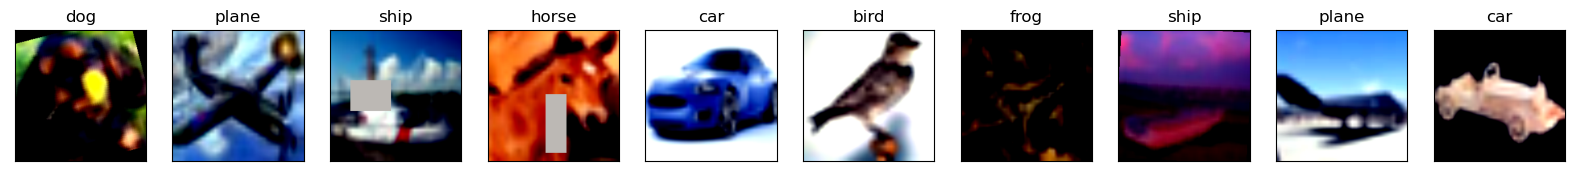

In [11]:
# Overview of the CIFAR-10 Dataset (image)
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

# Display an overview of data
def overview_data(loader, classes, num_images=5):
    data_iterable = iter(loader)  # Convert the loader to an iterable
    images, labels = next(data_iterable)  # Get the first batch

    num_images = min(num_images, len(images))  # Limit to the batch size
    fig = plt.figure(figsize=(20, 10))  # Create figure

    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])  # Add subplot
        plt.imshow(im_convert(images[idx]))  # Convert and display image
        ax.set_title(classes[labels[idx].item()])  # Set title

    plt.show()  # Display the figure

# Preview some data
overview_data(train_loader, classes, num_images=10)


# Models

### AlexNet: 8 layers (the first 5 of which are convolutional, and the last 3 are fully connected)


In [12]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [13]:
class AlexNetWithSkipConnections(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetWithSkipConnections, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )

        # 1x1 convolutions for skip connections
        self.conv1x1_residual1 = nn.Conv2d(3, 96, kernel_size=1)  # To match layer1 output channels
        self.conv1x1_residual2 = nn.Conv2d(256, 384, kernel_size=1)  # To match layer3 output channels

    def forward(self, x):
        residual1 = x  # Save input for the first skip connection
        out = self.layer1(x)

        # Skip connection 1: Input to layer2
        residual1 = nn.functional.interpolate(residual1, size=out.size()[2:], mode="bilinear", align_corners=False)
        residual1 = self.conv1x1_residual1(residual1)  # Match channel dimensions
        out = out + residual1  # Add skip connection

        out = self.layer2(out)

        # Save output of layer2 for second skip connection
        residual2 = out

        out = self.layer3(out)

        # Skip connection 2: Between layer2 and layer3
        residual2 = self.conv1x1_residual2(residual2)  # Match channels to 384
        out = out + residual2  # Add skip connection

        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

# Train


## EXPERIMENT 1: INIT (Random, Xavier, He)


In [14]:
# Random initialization (default)
def random_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)  # Random normal initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Xavier initialization
def xavier_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# He initialization
def he_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
def initialize_model(model, init_type):
    """
    Initializes the weights of the model using the specified initialization method.

    Args:
        model (nn.Module): The model to initialize.
        init_type (str): The type of initialization ('random', 'xavier', 'he').

    Returns:
        nn.Module: The initialized model.
    """
    if init_type == 'random':
        model.apply(random_init)
    elif init_type == 'xavier':
        model.apply(xavier_init)
    elif init_type == 'he':
        model.apply(he_init)
    else:
        raise ValueError(f"Unknown initialization type: {init_type}")
    return model


In [15]:
def train_model(
    model, 
    train_loader, 
    dev_loader, 
    init_type,
    num_epochs=15, 
    learning_rate=0.005, 
    weight_decay=0.005, 
    momentum=0.9, 
    save_path="best_model.pth",
):
    model = model.to(device)
    model = initialize_model(model, init_type)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_val_acc = 0.0  # Best validation accuracy for saving model

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Metrics calculation
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description
            train_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print("-"*50)
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

        # Training confusion matrix and report
        cm_train = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nTraining Confusion Matrix:")
        print(cm_train)

        if classes:
            print("\nTraining Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        val_bar = tqdm(dev_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Metrics calculation
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update tqdm description
                val_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dev_loader)
        epoch_acc = 100 * correct / total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)
        
        print("-"*50)
        print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%")

        # Validation confusion matrix and report
        cm_val = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nValidation Confusion Matrix:")
        print(cm_val)

        if classes:
            print("\nValidation Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Save the best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path} with Val Accuracy: {epoch_acc:.2f}%")

    print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.2f}%")
    return train_loss, val_loss, train_acc, val_acc


In [16]:
def get_model(model_type="alexnet", num_classes=10):
    """
    Returns a model based on the specified model type.
    
    Parameters:
    - model_type: str, either "alexnet" or "alexnet_skip".
    - num_classes: int, the number of output classes.
    
    Returns:
    - nn.Module: PyTorch model instance.
    """
    if model_type == "alexnet":
        return AlexNet(num_classes=num_classes)
    elif model_type == "alexnet_skip":
        return AlexNetWithSkipConnections(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Choose 'alexnet' or 'alexnet_skip'.")


# Choose the model type
model_type = "alexnet_skip"  # Change this to "alexnet" or "alexnet_skip" as needed
model_type = "alexnet"

# Dynamically get the model
model = get_model(model_type=model_type, num_classes=num_classes)

In [17]:
# Train and validate
train_loss, val_loss, train_acc, val_acc = train_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    init_type='random', # 'random', 'xavier', 'he'
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    momentum=momentum,
    save_path="best_model.pth"
)


Epoch 1/15


KeyboardInterrupt: 

# Testing (the best epochs on test data)


In [ ]:
def evaluate_best_model(
    model, 
    test_loader, 
    load_path="best_model.pth",
):
    """
    Evaluate the best saved model on test data and display results.
    """
    # Load the best model weights
    model.load_state_dict(torch.load(load_path))
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    print("\nEvaluating the best model on test data...")
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Metrics calculation
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect predictions and labels for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # GPU memory management
            del images, labels, outputs

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    if classes:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=classes))

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes if classes else np.arange(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Test Data")
    plt.show()

    return accuracy, cm



Evaluating the best model on test data...



Test Accuracy: 83.76%

Confusion Matrix:
[[903   1  20  13  12   4   2   5  30  10]
 [ 22 894   1   4   0   4   1   0  23  51]
 [ 68   1 760  54  26  31  24  20  11   5]
 [ 20   1  45 711  29 128  31  11  12  12]
 [ 24   1  32  51 816  18  19  25   9   5]
 [  9   0  40  94  18 792  11  27   6   3]
 [  8   2  28  56  16  19 849   5  10   7]
 [ 17   0  16  38  34  31   5 843   3  13]
 [ 64   6   2   4   0   1   2   2 910   9]
 [ 36  28   8   8   1   3   0   2  16 898]]

Classification Report:
              precision    recall  f1-score   support

       plane       0.77      0.90      0.83      1000
         car       0.96      0.89      0.92      1000
        bird       0.80      0.76      0.78      1000
         cat       0.69      0.71      0.70      1000
        deer       0.86      0.82      0.84      1000
         dog       0.77      0.79      0.78      1000
        frog       0.90      0.85      0.87      1000
       horse       0.90      0.84      0.87      1000
        ship    

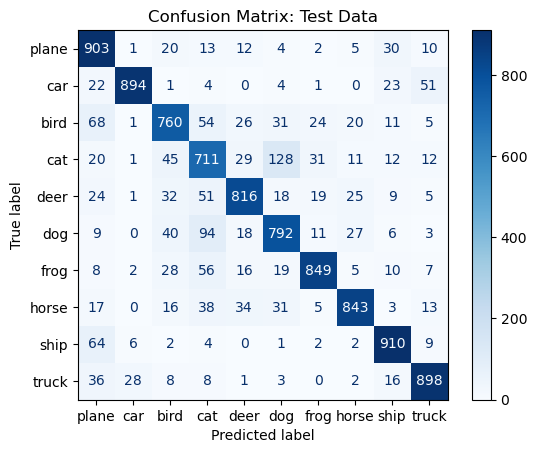

In [ ]:
test_accuracy, test_cm = evaluate_best_model(
    model=model, 
    test_loader=test_loader, 
    load_path="best_model.pth",
)